In [48]:
import sys
sys.path.append('../.')
from utils import *
from vqls import *

# set True to reproduce the experiments
reproduce = True
# Choose the function
flab = 'elu'


In [49]:
# Variable setting

n_step = 20 

func_dict, func_out, lower, upper = get_func('vqs')


step = (upper-lower)/n_step
f_i = func_dict[flab]
func = func_out[flab]

# target function
x = np.arange(lower, upper + .03, step).tolist()
y = [func(value,f_i) for value in x]
seeds = []
M = []
Y = []

q_weights=[]
c_coeff=[]
k_list=[]
tr_costs =[]
for i in range(1, len(x)):
    eq1 = pd.Series([1, x[i - 1]])
    eq2 = pd.Series([1, x[i]])
    M_c = pd.concat([eq1, eq2], axis=1).transpose()
    Y.append([y[i - 1], y[i]])
    M.append(M_c)


In [50]:
# To reproduce the results shown in the paper 
#notice that these reproduce the experiments with n_steps = 20
settings =  {'sigmoid':{ 'starting_points':[0.000352, 0.000477, 0.000838, 0.000129, 0.000235, 0.000638, 4.2e-05, 0.000198, 0.00022099999999999998, 0.0005989999999999999, 0.000864, 0.0005899999999999999, 0.000384, 0.000444, 0.000196, 0.00056, 0.000721, 0.00045599999999999997, 0.000472, 0.000274],
                        'seeds': [1795, 3887, 161, 694, 5335, 7020, 4029, 8615, 2318, 2204, 6687, 8530, 1223, 8410, 1773, 9797, 8999, 8909, 9411, 2282]},
            'sin':{ 'starting_points': [2.290409343023285, 2.913835091216079, 2.6315996985431194, 2.2848181366007245, 2.0260857651207105, 0.8663405843951512, 0.5180586071678102, 1.8686136505600985, 2.48334895556126, 1.5458257749520197, 0.4387085223872024, 2.983705131183795, 1.7324383177350422, 0.22402106731382312, 1.1116699927837574, 0.3151792343715475, 0.7377979016822057, 1.6607286470850429, 1.4712243411333281, 0.33102329925106083],
                                    'seeds': [9262, 3259, 3251, 1237, 5605, 8709, 8222, 4914, 1269, 3430, 4954, 4126, 4285, 2012, 487, 4154, 5766, 5975, 7854, 7423]},
            'elu':{ 'starting_points': [None]*20,
                                    'seeds': [7508, 9619, 9073, 8902, 9844, 3185, 6157, 8337, 4372, 8217, 1146, 2721, 1378, 1762, 983, 5957, 5692, 2411, 4827, 1248]},
            'relu':{ 'starting_points': [2.241232159480545, 1.2641135105884034, 2.044705092123057, 1.2018970452890185, 1.701046886813287, 2.4682144908299186, 0.4702848108535861, 2.3322122097215785, 2.3747857506196293, 3.04319357946408, 0.4358111554176937, 0.06584849015344461, 1.000504477530685, 1.0040369230786415, 0.9462360231220527, 2.593780543390448, 1.8489719139603042, 0.13265374653407164, 1.9778667839014408, 2.5066369945464877],
                                    'seeds': [8664, 8583, 7761, 8372, 3949, 793, 4849, 3424, 9686, 1953, 4473, 2017, 6233, 4323, 3489, 2483, 1430, 1429, 9858, 4367]},
            'none':{ 'starting_points': [None]*20,
                                    'seeds': [None]*20}}

if reproduce:
    params = settings[flab]
else:
    params = settings['none']


## Training V($\theta$)


In [54]:
for i in range(len(M)):
        matrix = M[i]
        vector = Y[i]
        if vector == [0.0, 0.0]:
            vector = [.000001, 0.00001] 
        v_norm = vector/np.linalg.norm(vector)
        vqls_circuit = VQLS(matrix,v_norm,1, seed =params['seeds'][i]) 
        weights = vqls_circuit.train(max_iter=300, warm_start=params['starting_points'][i]) 
        q_weights.append(weights)
        seeds.append(vqls_circuit.rng_seed)
        tr_costs.append(vqls_circuit.cost_vals)
        k_numb=np.linalg.cond(np.array(matrix))
        k_list.append(k_numb)
        


## Quantum inner product

In [56]:
x = np.arange(lower, upper, step).tolist()
qprod = qProduct(1)
y_q = []
for j in range(len(x)):
    point = [1,x[j]]
    y_q.append(qprod.direct_prod2(q_weights[j],point).item())  


## Visualize

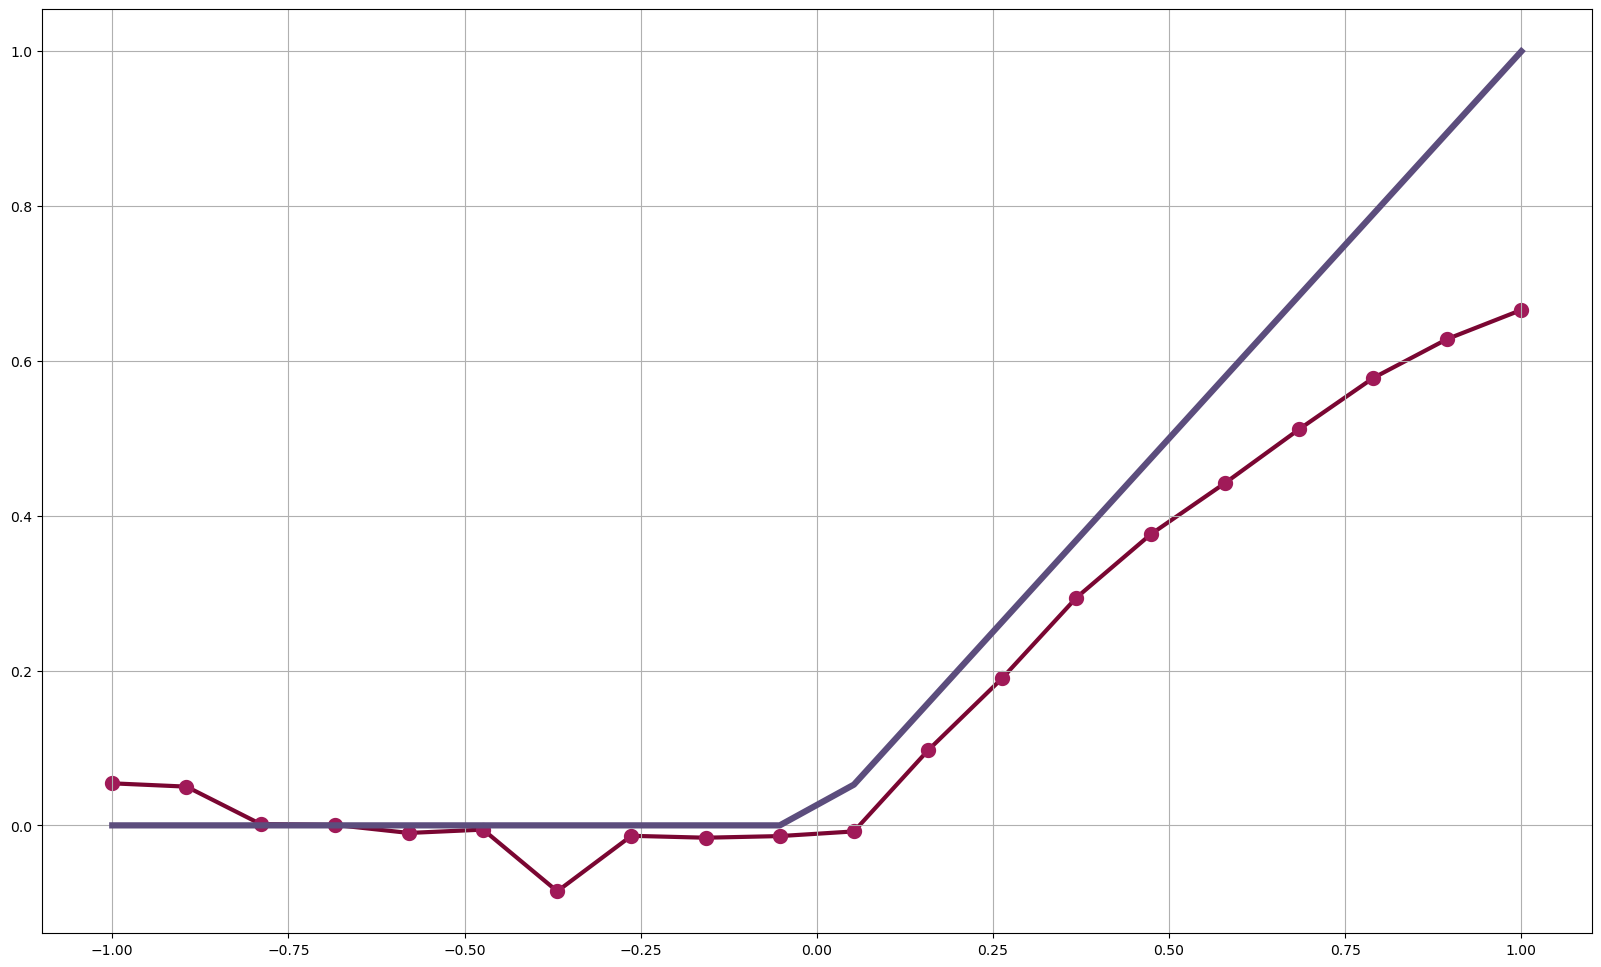

In [57]:
x = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]


fig = plt.figure(tight_layout = False, figsize=(20,12))
plt.grid(zorder = -3)
plt.plot(x,y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=4.5)

colorl = '#7a0632'
colors = '#a01a58'

plt.plot(x,y_q, color=colorl, zorder= -1, lw=3)
plt.scatter(x,y_q, color=colors, linewidths=5)

plt.show()